In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Loading the data

In [2]:
df = pd.read_parquet('../../data/concatenated_online_retail_II.parquet') \
                    .rename(columns={'Customer ID': 'CustomerID'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  string        
 1   StockCode    1067371 non-null  string        
 2   Description  1062989 non-null  string        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   CustomerID   824364 non-null   float64       
 7   Country      1067371 non-null  string        
 8   Year         1067371 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), string(4)
memory usage: 73.3 MB


In [3]:
df.describe()

,Quantity,InvoiceDate,Price,CustomerID,Year
count,1.067371e+06,1067371,1.067371e+06,824364.000000,1.067371e+06
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504,1.507705e+00
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000,1.000000e+00
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000,1.000000e+00
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000,2.000000e+00
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000,2.000000e+00
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000,2.000000e+00
std,1.727058e+02,NaN,1.235531e+02,1697.464450,4.999409e-01


## Computing Recency, Frequency, Monetary Value, and Tenure

First, we define a snapshot date – a simulated point in time when we run the analysis.

In [4]:
days_passed = 1
snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=days_passed)

Then we group by customer ID and calculate the RMF-T metrics.
* **Recency**: Number of days since the last purchase for each customer.
* **Frequency**: Number of purchases made by each customer.
* **MonetaryValue**: Total amount spent by each customer.
* **Tenure**: Number of days each customer has been active.

In [5]:
rmft = df.groupby('CustomerID').agg(
    Recency = ('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    Frequency = ('Invoice', 'count'),
    MonetaryValue = ('Price', 'sum'),
    Tenure = ('InvoiceDate', lambda x: (x.max() - x.min()).days)
)
rmft

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
12346.0,326,48,580.44,400
12347.0,2,253,644.16,402
12348.0,75,51,193.10,362
12349.0,19,180,1504.59,716
12350.0,310,17,65.30,0
...,...,...,...,...
18283.0,4,986,1719.75,654
18284.0,430,29,116.09,2
18285.0,661,12,100.20,0


## Clustering
### Preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler
log_rmft = np.log1p(rmft)
scaler = StandardScaler()
scaled_rmft = pd.DataFrame(scaler.fit_transform(log_rmft), columns=rmft.columns, index=rmft.index)
scaled_rmft.describe()

,Recency,Frequency,MonetaryValue,Tenure
count,5.942000e+03,5.942000e+03,5.942000e+03,5.942000e+03
mean,-3.121031e-16,5.234603e-16,2.822082e-16,-2.391595e-17
std,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00
min,-2.357189e+00,-2.368299e+00,-3.445497e+00,-1.551241e+00
25%,-7.427957e-01,-6.485059e-01,-6.144773e-01,-1.551241e+00
50%,8.588894e-02,-4.493552e-03,2.582970e-02,5.130351e-01
75%,9.486214e-01,7.039300e-01,6.831079e-01,8.289068e-01
max,1.364803e+00,3.933870e+00,4.064607e+00,9.642227e-01


### Model selection

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters = list(range(2, 11))
sil_scores = []
sse = []
for k in n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=1, n_init='auto')
    kmeans.fit(scaled_rmft)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(scaled_rmft, kmeans.labels_))

k_sel_df = pd.DataFrame({'silhouette_score': sil_scores, 'sse': sse}, index=n_clusters)

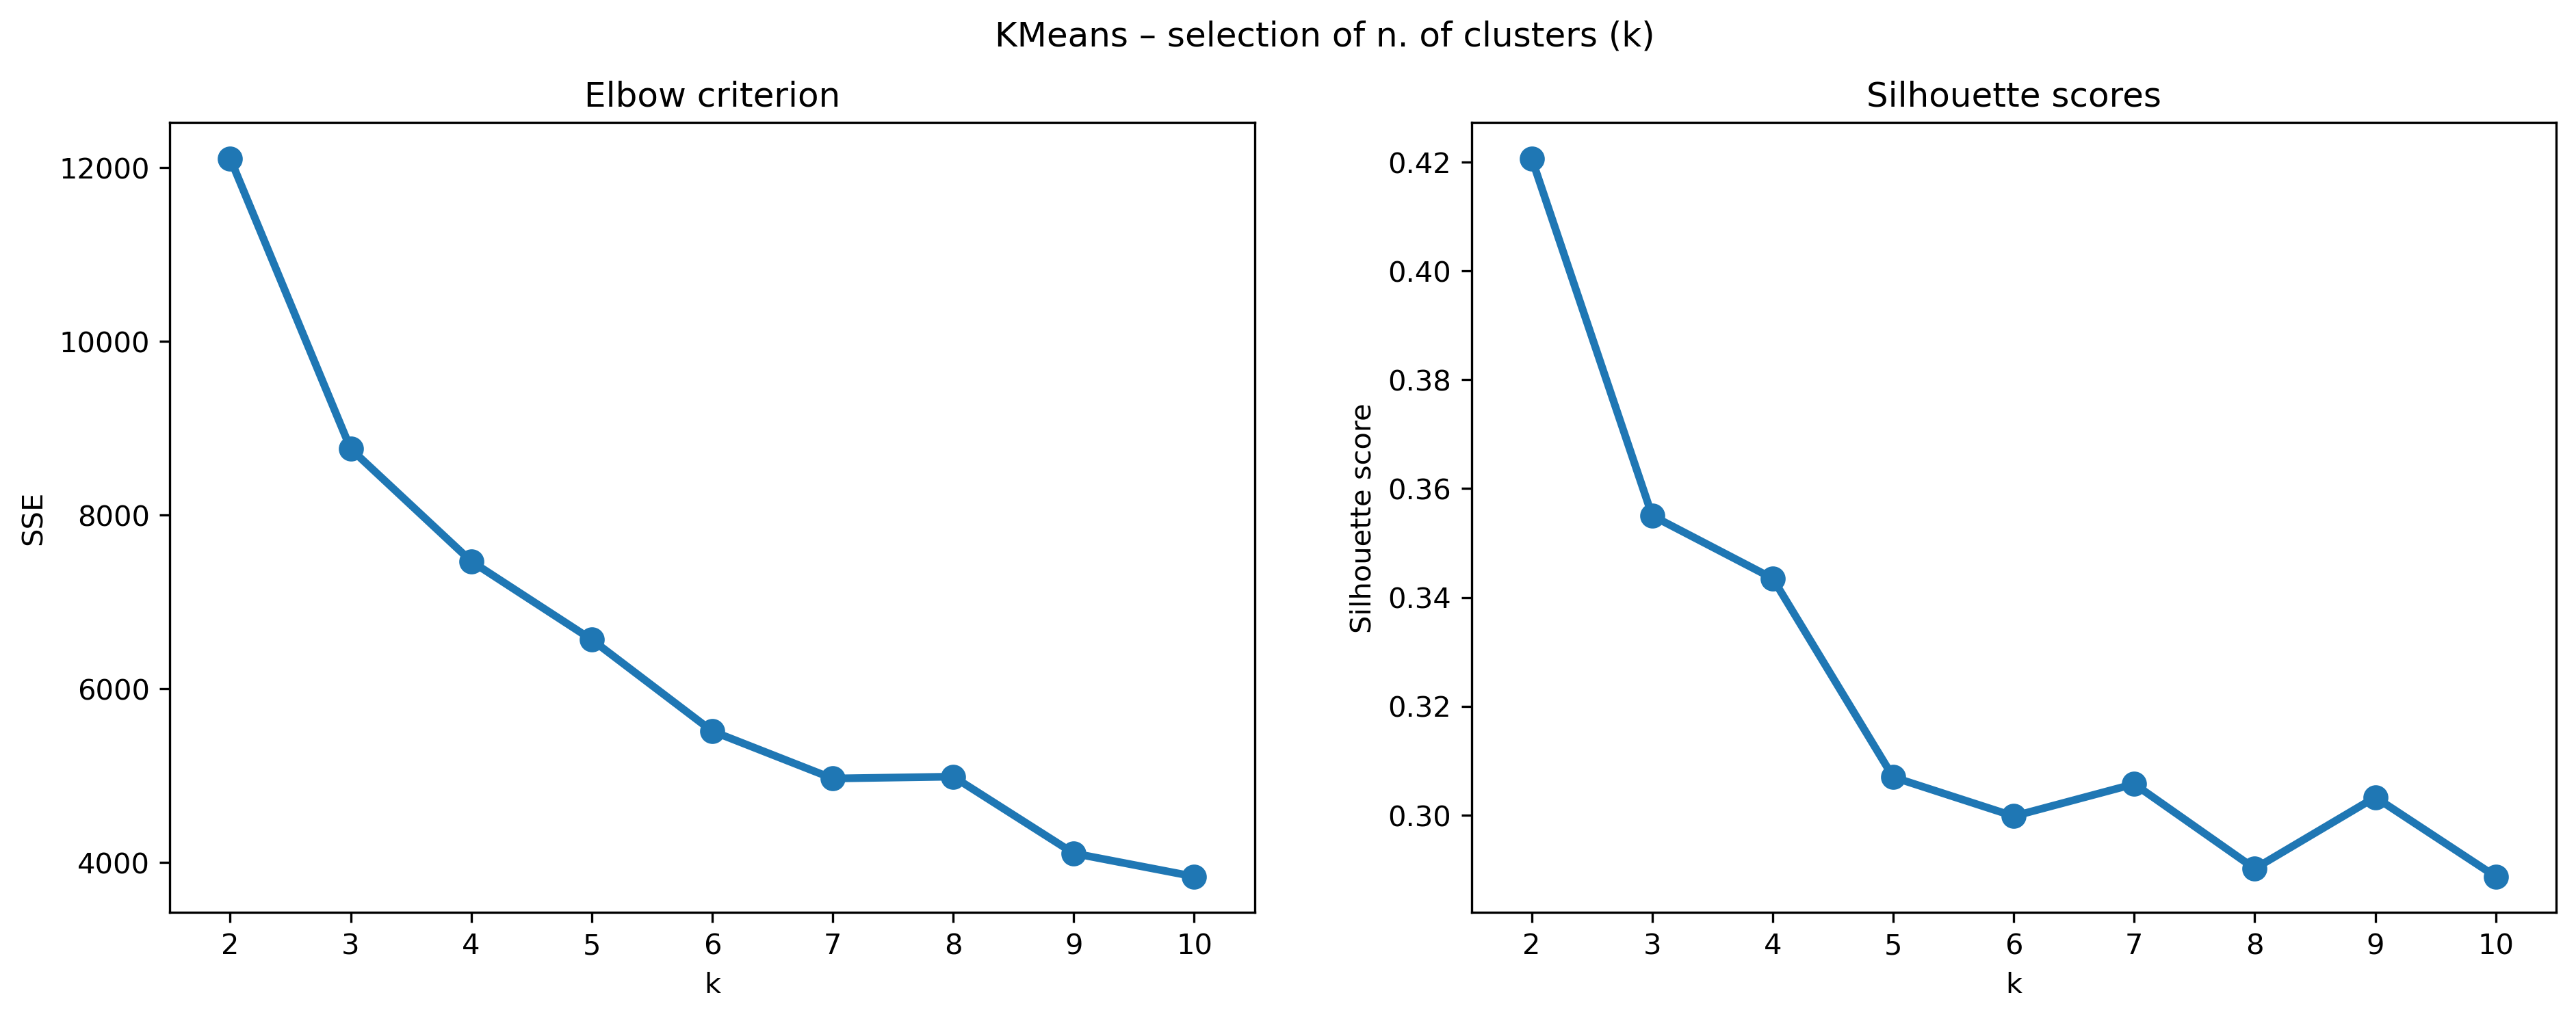

In [9]:
fig, axes = plt.subplots(1,2, figsize=(15,5), dpi=300)

sns.pointplot(k_sel_df, x=k_sel_df.index, y='sse', ax=axes[0])
axes[0].set_title("Elbow criterion")
axes[0].set_xlabel('k'); axes[0].set_ylabel('SSE')

sns.pointplot(k_sel_df, x=k_sel_df.index, y='silhouette_score', ax=axes[1])
axes[1].set_title("Silhouette scores")
axes[1].set_xlabel('k'); axes[1].set_ylabel('Silhouette score')
plt.suptitle("KMeans – selection of n. of clusters (k)")
plt.show()

### Predictions

In [10]:
rmft_k = rmft.copy()
k_cols = []
for k in range(2,4):
    model = KMeans(n_clusters=k,random_state=1,  n_init='auto')
    col_name = f'k{k}'
    rmft_k[f'k{k}'] = model.fit_predict(scaled_rmft)
    k_cols.append(col_name)
k_summaries = {k:rmft_k.groupby(k).median().iloc[:,:-1] for k in k_cols}

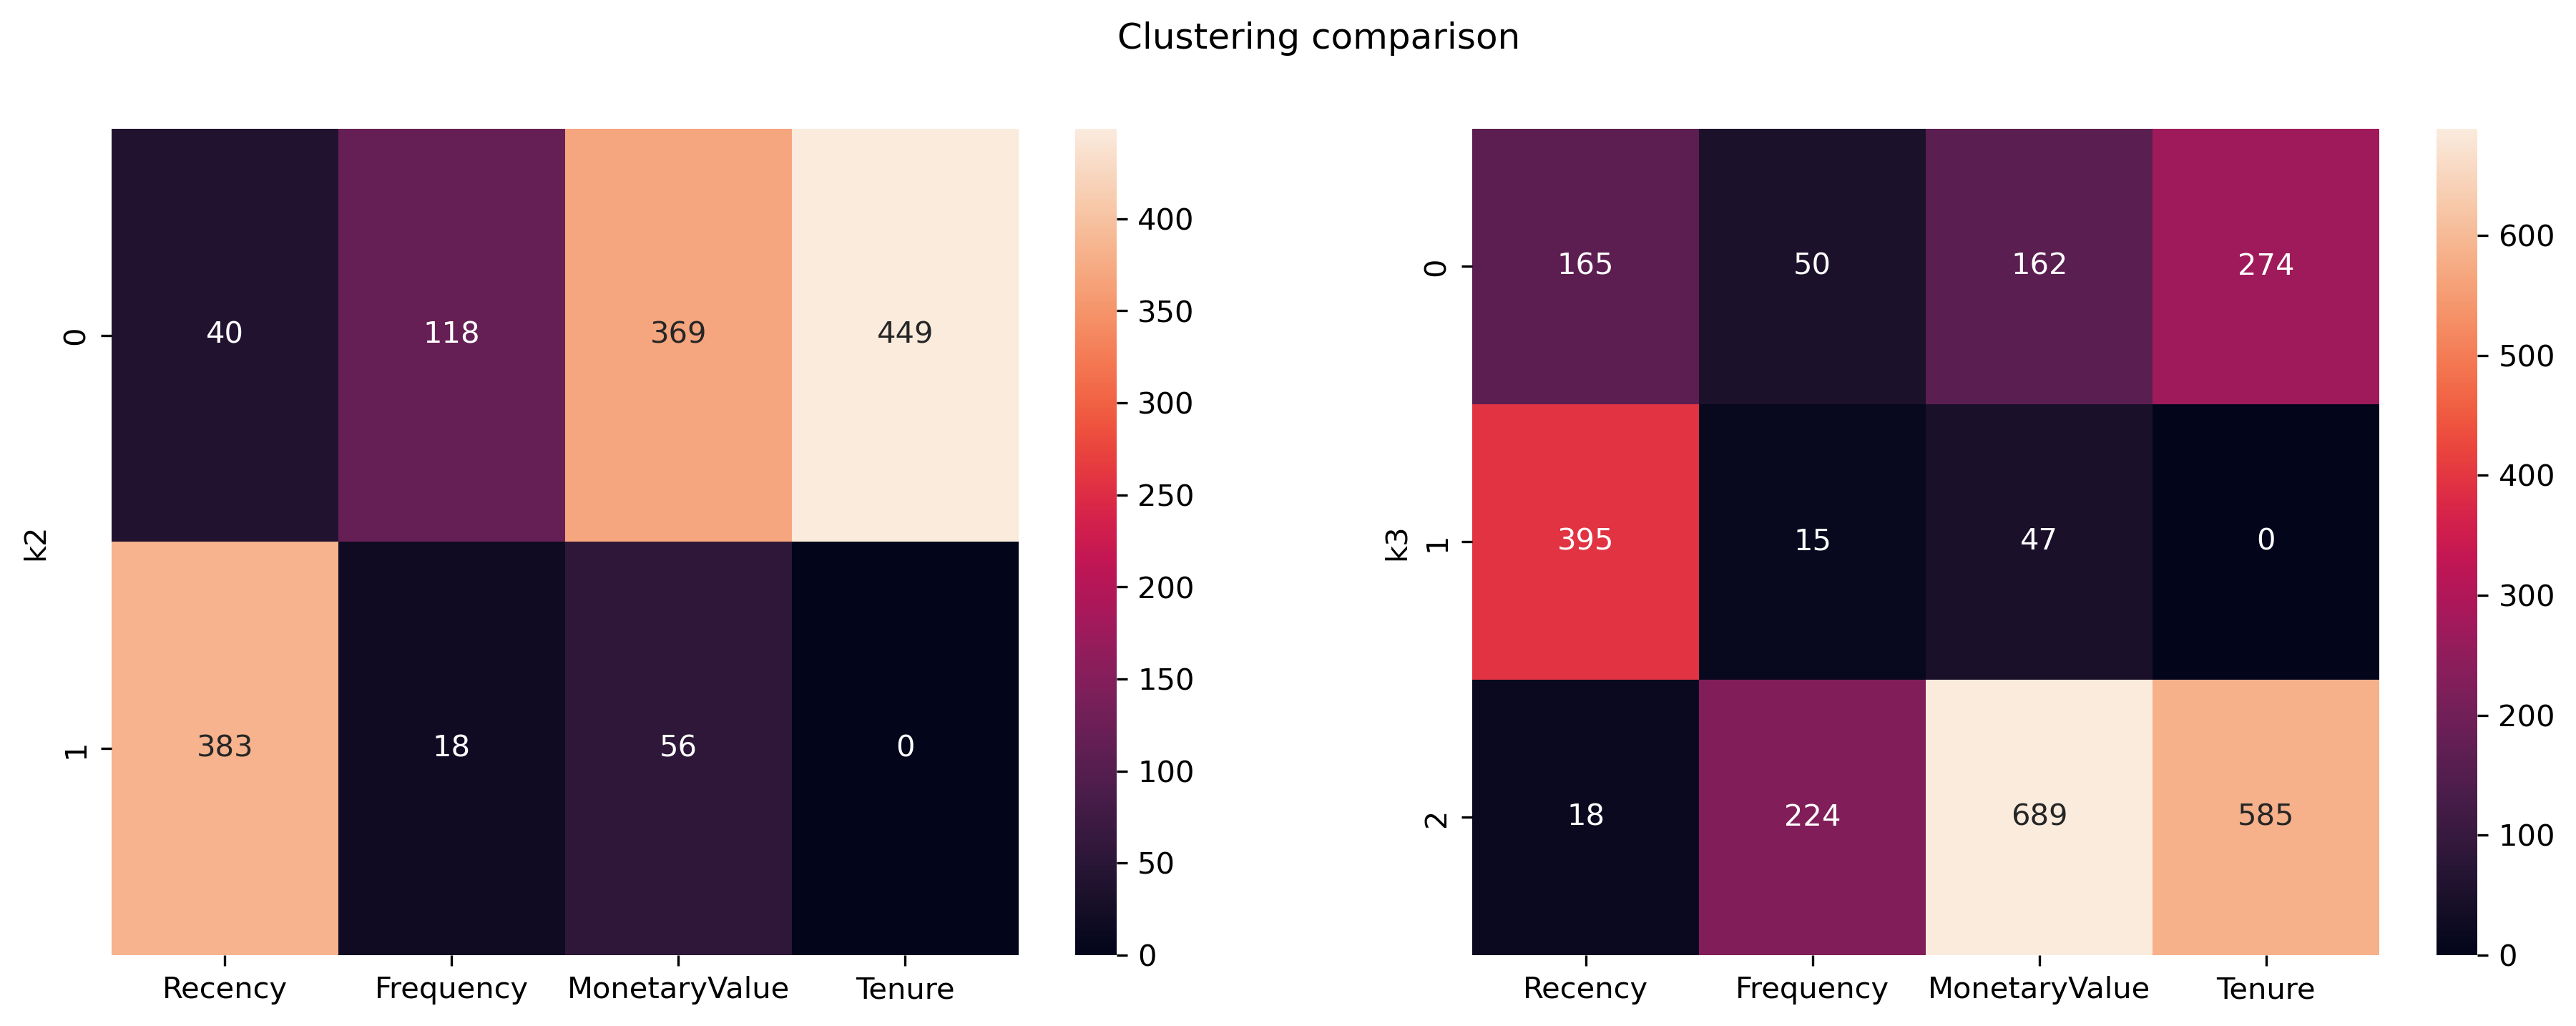

In [11]:
fig, ax = plt.subplots(1, len(k_summaries.keys()), figsize=(15,5), dpi=300)
for n, summary in enumerate(k_summaries.values()):
    sns.heatmap(summary.round(), annot=True, ax=ax[n], fmt="g")
plt.suptitle('Clustering comparison')
plt.show()

K2 Clustering (2 Clusters):
* **Cluster 0 (High Tenure and Spend)**: Customers with moderate Recency, meaning their last purchase was relatively recent. They don't purchase very frequently, but when they do, they tend to spend a lot. Their Tenure is high, indicating they have been customers for a long time.

* **Cluster 1 (Newer, Less Engaged)**: These customers have been engaged more recently, but their overall Frequency and MonetaryValue are low. They have zero Tenure, which could mean they are new customers.

K3 Clustering (3 Clusters):
* **Cluster 0 (Occasional Big Spenders)**: This cluster's customers have a moderately recent last purchase, they buy infrequently, but they tend to spend more. Their Tenure is moderate, suggesting they are neither new nor long-time customers.

* **Cluster 1 (New, Growing Relationship)**: Customers here have the most recent engagement, moderate purchase frequency, and have spent a moderate amount. They are likely relatively new, as indicated by the lower Tenure.

* **Cluster 2 (Loyal and Frequent Customers)**: These customers have less recent engagement compared to the others but have the highest purchase frequency and spend the most, with the longest Tenure. They represent well-established, loyal customers who are valuable to the business.

Customer Profiles Based on Clustering:
* **K2 Cluster 0 (Established Valuable Customers)**: These customers are valuable due to their high spend per purchase. Since they're established with high tenure, retention strategies should focus on increasing purchase frequency.

* **K2 Cluster 1 (New or Inactive Customers)**: They need nurturing to develop into more valuable customers. Welcome campaigns, educational content about products, and incentives to make the second purchase could be effective.

* **K3 Cluster 0 (Mid-Tier Customers)**: They may need encouragement to purchase more frequently or to continue their pattern of high spending. Membership programs or tiered rewards could motivate more frequent engagement.

* **K3 Cluster 1 (Emerging Customers)**: These customers are in the early stages of their lifecycle but show promise with moderate frequency and spending. Onboarding strategies, first-purchase thank-you discounts, and product recommendations could build their engagement.

* **K3 Cluster 2 (Core Customers)**: This group is likely responsible for a significant portion of revenue due to their frequent purchases and high spending over a long period. Retention is critical, and personalized experiences or rewards for their loyalty can be very effective.

Strategies for Each Cluster:
For Established Valuable Customers (K2 Cluster 0): Since their purchase frequency is low, targeted offers based on past purchase behavior, reminders for repurchase, and cross-selling strategies can be applied.

For New or Inactive Customers (K2 Cluster 1): Engagement campaigns that educate about the brand and provide incentives for increased interaction and purchasing can help move them along the customer journey.

For Mid-Tier Customers (K3 Cluster 0): Consider creating personalized marketing campaigns that reward their spending habits and encourage more frequent purchases.

For Emerging Customers (K3 Cluster 1): Develop nurture campaigns with incentives for repeat purchases and personalized recommendations based on their initial purchases.

For Core Customers (K3 Cluster 2): Implement VIP programs, exclusive access to products, and personalized services that acknowledge their loyalty and high value to the brand.